In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf


In [2]:
import pandas as pd

# Define the data
data_dic = {
    'Sample': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
               11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
               21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
               31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    'X': [0.00, 0.03, 0.05, 0.23, 0.07, 0.19, 0.23, 0.17, 0.19, 0.02, 
          -0.08, -0.05, 0.04, 0.33, 0.15, 0.21, 0.15, -0.08, -0.08, -0.30, 
          -0.11, -0.26, -0.17, -0.25, -0.16, -0.24, -0.13, -0.05, 0.15, 0.07, 
          -0.17, -0.21, -0.02, -0.19, 0.00, -0.04, 0.16, -0.14, -0.07, -0.24]
}

# Create the DataFrame
data= pd.DataFrame(data_dic)

# Display the DataFrame
data.head()



,Sample,X
0,1,0.00
1,2,0.03
2,3,0.05
3,4,0.23
4,5,0.07


Number of points n = 40
Mean = -0.02


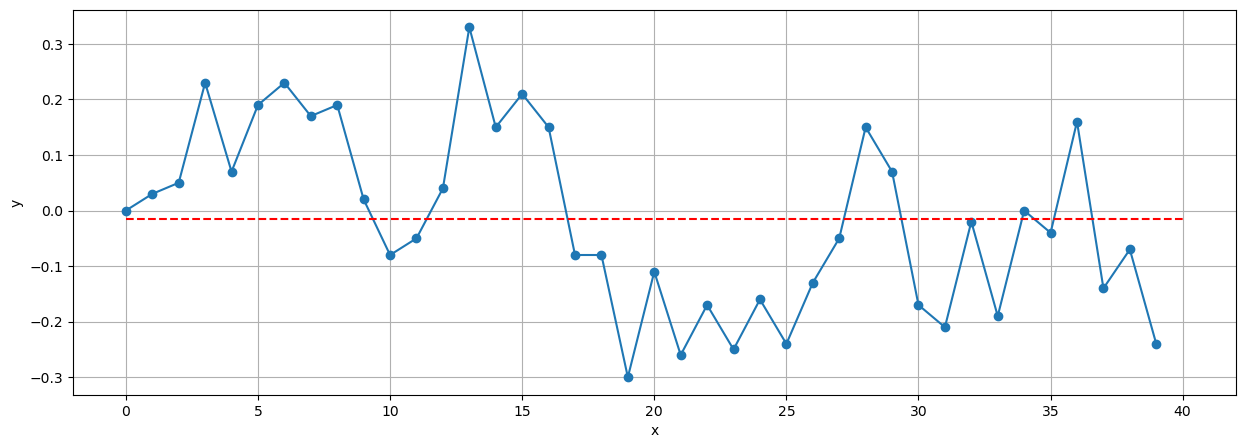

In [4]:
mf.single_ts_plot(data['X'])

p-value of the Shapiro-Wilk test: 0.325


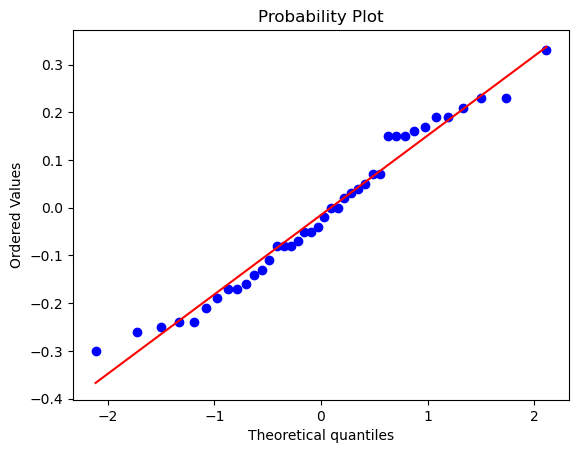

Accept H0: the data are normal


In [5]:
mf.shapiroqq(data['X'])

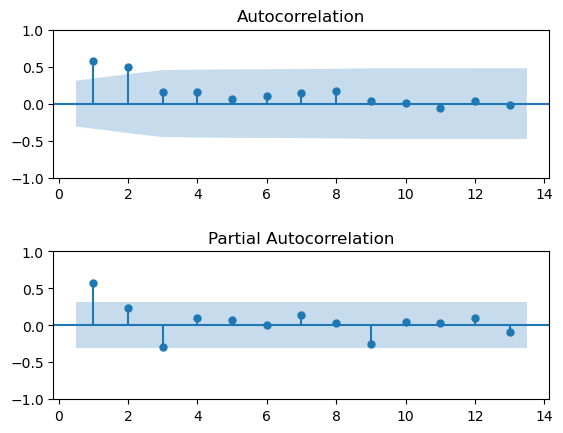

In [6]:
mf.acfpacf(data['X'])

In [7]:
data['lag1']=data['X'].shift(1)

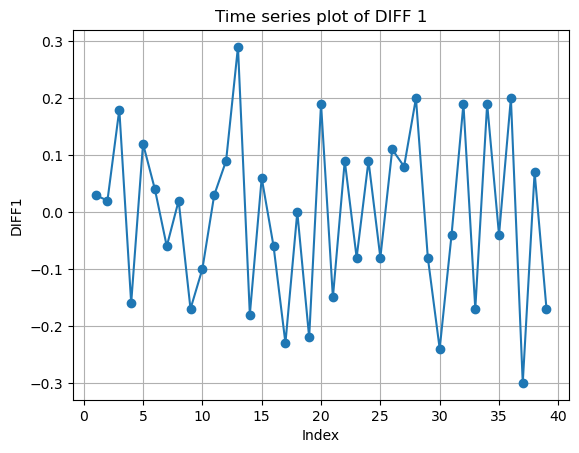

Runs test statistic = 2.487
Runs test p-value = 0.013
Reject H0: the data are not random


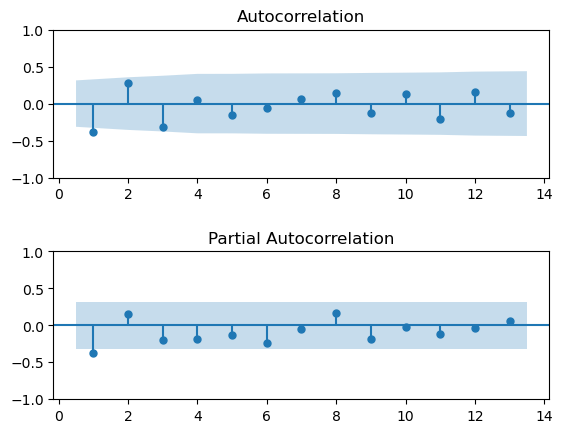

In [8]:
data['diff_1']=mf.diffprocess(data,'X','lag1',1)

In [9]:
mf.bartlett_test (data['diff_1'], 1, alpha=0.05, salta=1)

Test statistic rk = -0.378748
Rejection region starts at 0.313845
The null hypothesis is accepted


l'idea iniziale vista apparente non stazionarietà della media (no trend ma media che shifta più che altro) era fare differenziazione. 
Tuttavia può essere anche visto come meandering stationary e quindi una cosa interessante è andare a vedere acfpacf e accorgersi che un modello potrebbe essere MA(2) ma anche AR(1) perchè dipende un po' dal pov che hai (non è proprio un caso chiarissimo). Proviamo MA(1) con ARIMA package!

In [10]:
y = data['X'] #variabile y, quella su cui voglio fittare
p=0
d=0
q=2

model = qda.ARIMA(y, order=(p,d,q), add_constant = False) #MA(2)
qda.ARIMAsummary(model)
residuals = model.resid[np.max((p,d,q)):] 
fits = model.fittedvalues[np.max((p,d,q)):] 


---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=0, q=2

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value    P-Value
ma.L1 0.5650   0.1592   3.5495 3.8590e-04
ma.L2 0.5373   0.1333   4.0313 5.5480e-05

RESIDUAL SUM OF SQUARES
-------------------------
  DF     SS     MS
38.0 0.5979 0.0157

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      5.1202   0.9538
  24     15.2942   0.9119
  36     24.4943   0.9271


Shapiro-Wilk test p-value on the residuals = 0.777


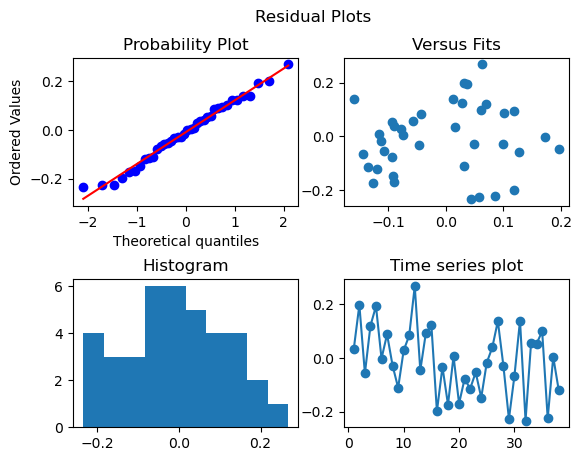

In [11]:
mf.shapirplusresplots(model,salta=2)

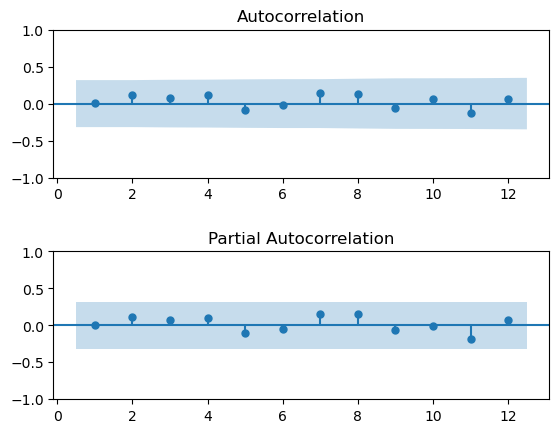

In [12]:
mf.acfpacf(residuals)

In [13]:
mf.runs(residuals)

Runs test statistic = -0.658
Runs test p-value = 0.511
Accept H0: the data are random


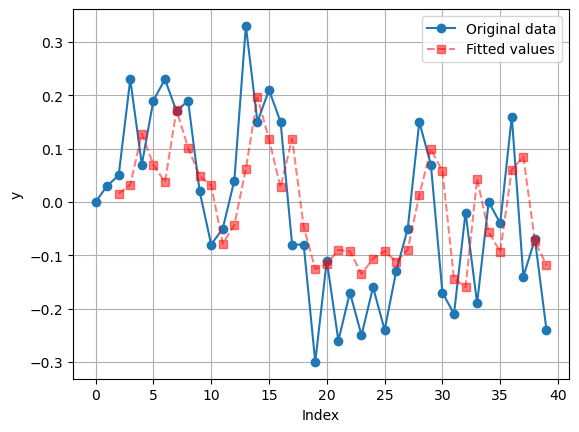

In [14]:
mf.plotyvsfits(y,model)

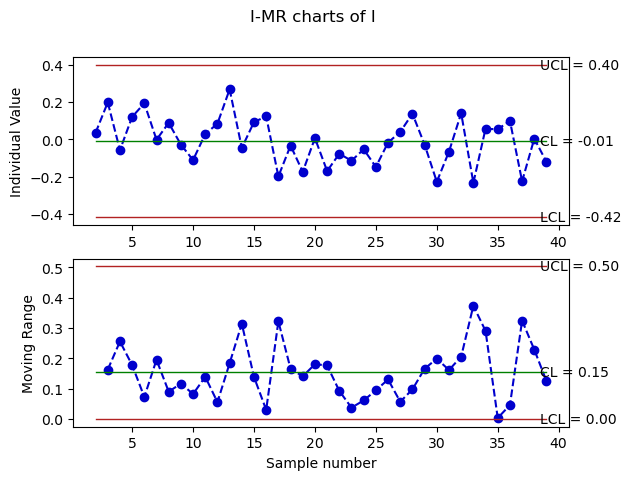

In [15]:
df_res = pd.DataFrame({'I': residuals})
df_SCC = qda.ControlCharts.IMR(df_res, 'I',K=3)

tutto IC, forse qualche pattern che indica che si sarebbe potuto costruire un modello migliore e un po' di hagging nell'I chart

c)The head of the quality department decides to test a different control charting method, which 
consists of batching the data with a batch size equal to 2. Design a suitable control chart based on 
this approach (with K = 3). 

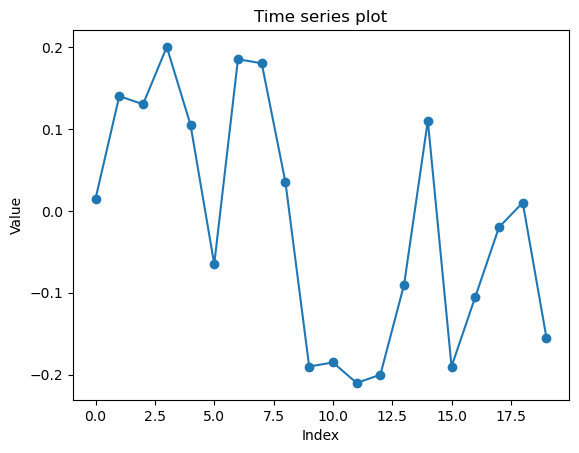

In [18]:
batch_data=mf.batching(data,'X',2)

In [19]:
batch_df=pd.DataFrame({'batch_data': batch_data})

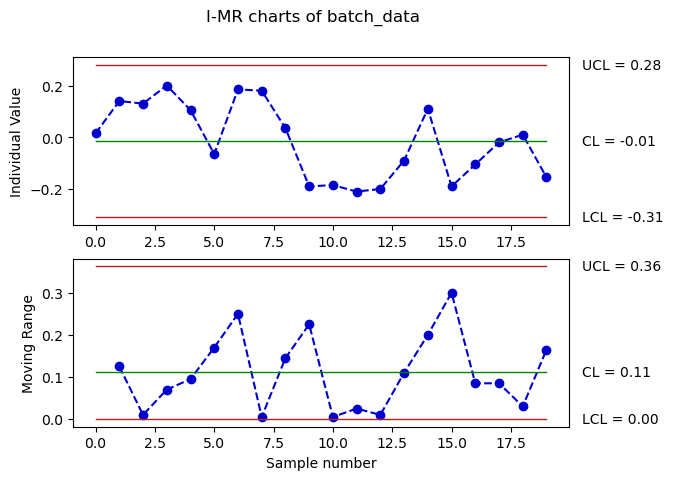

In [40]:
batch_CC=qda.ControlCharts.IMR(batch_df,'batch_data',K=3)
#ATTENZIONE!!! mica siamo sicuri che I-MR vada bene cosi come sono i nuovi dati batchati***!!!
#Bisogna checkare NID assumption!!!!!!!!

#*** un batching di livello 2 è poco o niente!!!
!infatti vedremo che tocca modellizzare e che questo è da buttare

In [21]:
mf.runs(batch_data)

Runs test statistic = -1.378
Runs test p-value = 0.168
Accept H0: the data are random


p-value of the Shapiro-Wilk test: 0.058


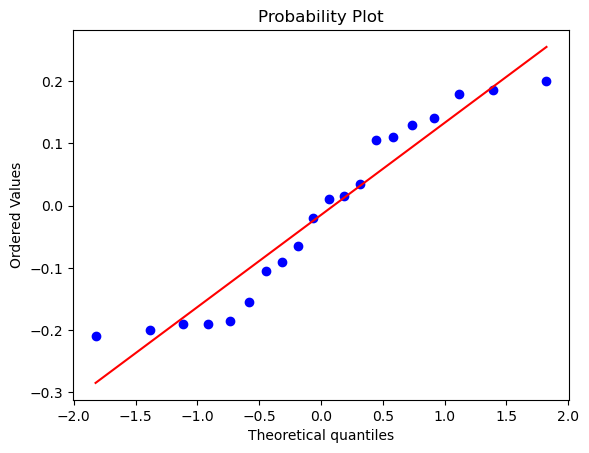

Accept H0: the data are normal


In [22]:
mf.shapiroqq(batch_df['batch_data'])
#accetta di pochissimo!

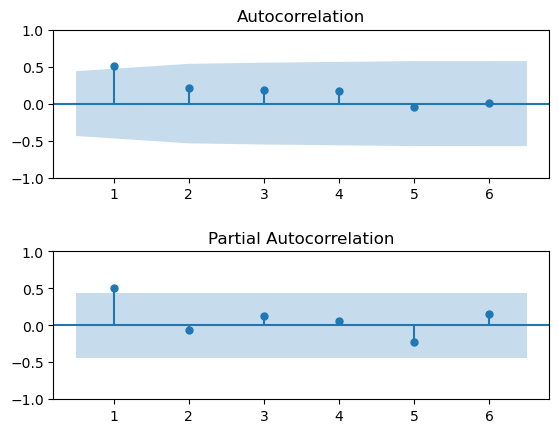

In [23]:
mf.acfpacf(batch_df['batch_data'])
#rimane dell'autocorrelazione!

un modello sensato sembra essere AR(1)!

In [35]:
y_b= batch_df['batch_data'] #variabile y, quella su cui voglio fittare
p=1
d=0
q=0

model_b = qda.ARIMA(y_b, order=(p,d,q), add_constant = False) #MA(2)
qda.ARIMAsummary(model_b)
residuals_b = model_b.resid[np.max((p,d,q)):] 
fits_b = model_b.fittedvalues[np.max((p,d,q)):] 

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=0, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value  P-Value
ar.L1 0.5099   0.2949   1.7288   0.0838

RESIDUAL SUM OF SQUARES
-------------------------
  DF     SS     MS
19.0 0.2963 0.0156

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      9.1126   0.6933


In [36]:
mf.runs(residuals_b)

Runs test statistic = -1.097
Runs test p-value = 0.272
Accept H0: the data are random


Shapiro-Wilk test p-value on the residuals = 0.964


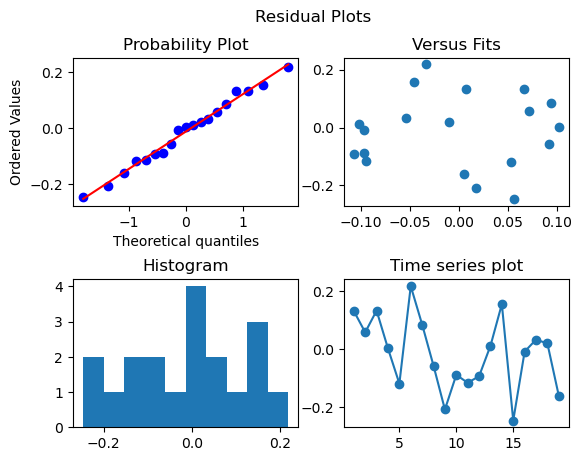

In [37]:
mf.shapirplusresplots(model_b,salta=1)

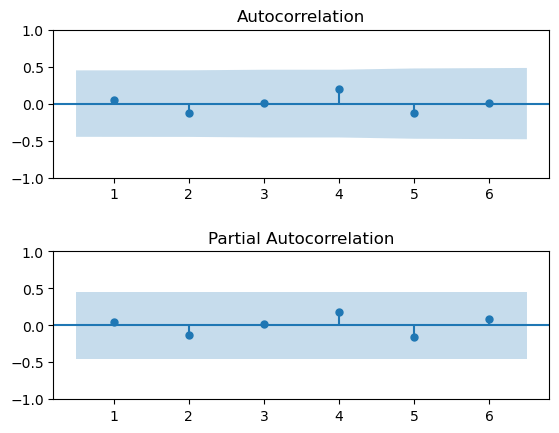

In [38]:
mf.acfpacf(residuals_b)

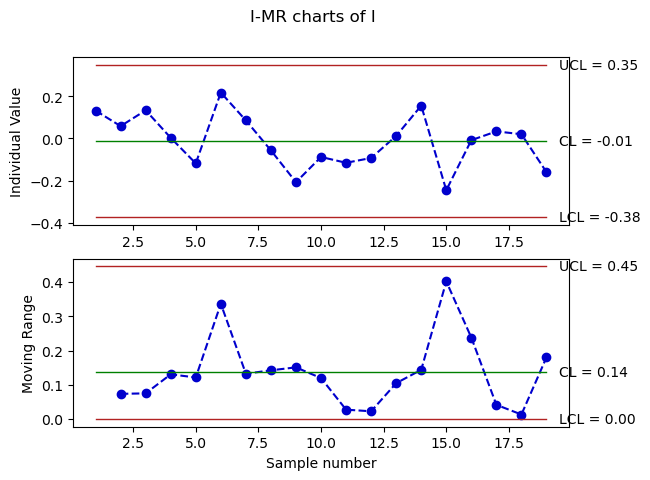

In [41]:
df_res_b = pd.DataFrame({'I': residuals_b})
df_SCC_b = qda.ControlCharts.IMR(df_res_b, 'I',K=3)

After some tests with different batch sizes on a more extended dataset, the quality department has 
finally found a way to get rid of the temporal dependence in the measurements. After the batching 
operation, the data are normal and independent, with mean 𝜇 = 0 and standard deviation 𝜎. In the 
presence of an out-of-control mean shift 𝛿𝜎, what is the minimum value of 𝛿 that can be detected 
with a power of 90%? (use K = 3). 


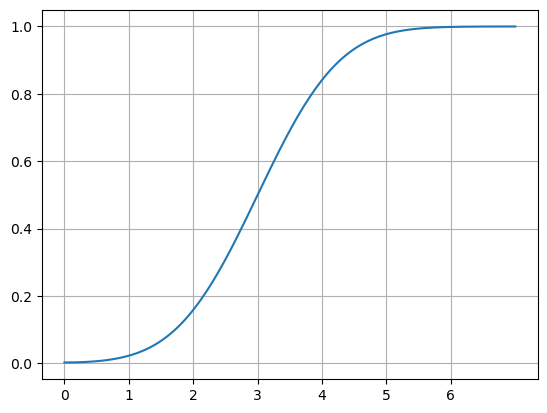

4.299999999999993
4.3499999999999925
4.399999999999992
4.449999999999992
4.499999999999992
4.549999999999992
4.599999999999992
4.6499999999999915
4.699999999999991
4.749999999999991
4.799999999999991
4.849999999999991
4.899999999999991
4.94999999999999
4.99999999999999
5.04999999999999
5.09999999999999
5.14999999999999
5.1999999999999895
5.249999999999989
5.299999999999989
5.349999999999989
5.399999999999989
5.449999999999989
5.4999999999999885
5.549999999999988
5.599999999999988
5.649999999999988
5.699999999999988
5.749999999999988
5.799999999999987
5.849999999999987
5.899999999999987
5.949999999999987
5.999999999999987
6.0499999999999865
6.099999999999986
6.149999999999986
6.199999999999986
6.249999999999986
6.299999999999986
6.349999999999985
6.399999999999985
6.449999999999985
6.499999999999985
6.549999999999985
6.5999999999999845
6.649999999999984
6.699999999999984
6.749999999999984
6.799999999999984
6.849999999999984
6.8999999999999835
6.949999999999983
6.999999999999983


In [49]:
delta_piccolo=np.linspace(0,7,150)
beta=stats.norm.cdf(3-delta_piccolo)-stats.norm.cdf(-3-delta_piccolo)
Power=1-beta
plt.plot(delta_piccolo,Power)
plt.grid()
plt.xticks(range(0, 7))
plt.show()

delta=0
for i in range(0,140):
    delta=0.05+delta
    beta=np.zeros(140)
    power=np.zeros(140)
    beta[i]=stats.norm.cdf(3-delta)-stats.norm.cdf(-3-delta)
    power[i]=1-beta[i]
    if(power[i])>0.9:
        print(delta)


la risposta è delta_piccolo=4.3